Implementation inspired by: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

# 0. Import packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV


# 1. Data preparation

## 1.1 Loading the data

#### Load the set of images and labels from the mnist dataset using Keras:
* When loading the dataset this way, it already is split into a training set (60000 images) and test set (10000)
* The dataset does not contain any missing values

In [5]:
(X_train,y_train),(X_test,y_test)=keras.datasets.mnist.load_data()

#### Displaying some of the images:

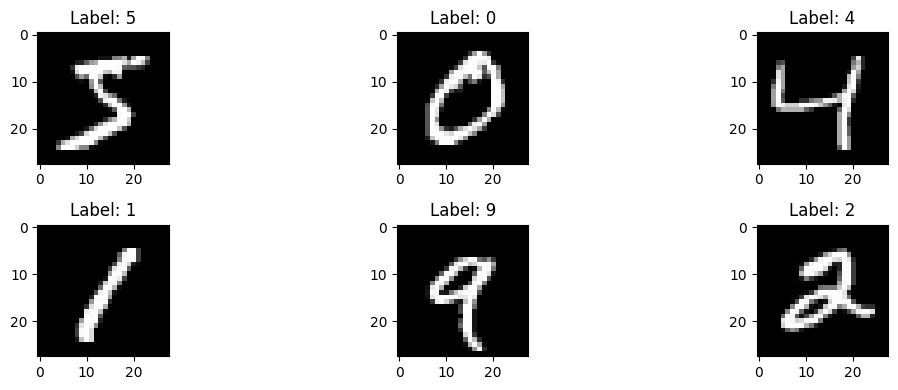

In [6]:
# Display a few example images
plt.figure(figsize=(12, 4))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

#### Reshape the images

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

#### Normalize images

In [8]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#### Label encoding

In [9]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [10]:
y_train.shape

(60000, 10)

#### Things to consider in this section:
* Reshaping the data (the data needs to be in a specific format before entering the model)
* Label encoding
* etc.

## 1.2 Data Augmentation
Apply techniques to diversify the diversity of our training data. Could for instance be: 
* Normalizing the images (for instance grayscale normalization)
* horizontal or vertical flips
* random crops 
* color jitters
* translations
* and more...

#### Data augmentation

In [11]:
def create_datagen(rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, fill_mode):
    datagen = ImageDataGenerator(rotation_range=rotation_range, # Rotating randomly the images up to 25° 10
                                 width_shift_range=width_shift_range, # Moving the images from left to right 0.1
                                 height_shift_range=height_shift_range, # Then from top to bottom 0.1
                                 shear_range=shear_range, # 0.1
                                 zoom_range=zoom_range, # Zooming randomly up to 20% 0.1
                                 fill_mode = fill_mode) # Nearest
    datagen.fit(X_train)
    return datagen

datagen = create_datagen(10, 0.1, 0.1, 0.1, 0.1, "Nearest")

# 2. CNN

## 2.1 Defining the model
* Define all the layers, including Conv2D (convolutional layers), MaxPool2D (pooling layers), dropout layers, flatten layer and dense layer
* Decide upon things like the optimizer, loss function, batch size, number of epochs and so on. Maybe introduce early stopping (a mechanism that makes the training of the network stop automatically once the value of the loss starts increasing)

In [52]:
def create_model(dropout):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu', strides=(2,2)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))

    # Set optimizer and compile
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    return model

model = create_model(0.4)

#### Set batch size and epochs

In [17]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

# 3. Data augmentation and train

#### Train the model

In [49]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

697/697 [==============================] - 45s 64ms/step - loss: 0.1072 - accuracy: 0.9667 - val_loss: 0.0553 - val_accuracy: 0.9830


## 2.2 Tuning the model - Magnus
We can tune are model to make sure that the hyperparameters we have chosen ensures opimal performance. Some hyperparameters that could be useful to tune (according to ChatGPT) are:
* Number of Convolutional layers
* Number of Filters
* Filter Size (Kernel Size)
* Pooling
* Dropout Rate
* Weight Initialization
* Data Augmentation
* and more...

In [61]:
"""
model = create_model(0.4)
epochs = 1
batch_size = 86

def tune_datagen(rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, fill_mode):
    datagen = create_datagen(rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, fill_mode)
    history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 0, steps_per_epoch=X_train.shape[0] // batch_size)
    return np.max(history.history['val_accuracy'])


# 'rotation_range', 'width_shift_range', 'height_shift_range', 'shear_range', 'zoom_range', 'fill_mode'
rotation_range = [0, 10, 20, 30]
width_shift_range = [0, 0.1, 0.2]
height_shift_range = [0, 0.1, 0.2]
shear_range = [0, 0.1, 0.2]
zoom_range = [0, 0.05, 0.1]
fill_mode = ['nearest', 'constant', 'reflect', 'wrap']

accuracies = []

for rotation in rotation_range:
    for width in rotation_range:
        for height in height_shift_range:
            for shear in shear_range:
                for zoom in zoom_range:
                    for fill in fill_mode:
                        val_accuracy = tune_datagen(rotation, width, height, shear, zoom, fill)
                        accuracies.append((rotation, width, height, shear, zoom, fill, val_accuracy))


                        
grid_search = GridSearchCV(estimator=tune_datagen, param_grid=param_grid, cv=3, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)
"""

[0, 10, 20, 30]
[0, 0.1, 0.2]
[0, 0.1, 0.2]
[0, 0.1, 0.2]
[0, 0.05, 0.1]
['nearest', 'constant', 'reflect', 'wrap']


'\ngrid_search = GridSearchCV(estimator=tune_datagen, param_grid=param_grid, cv=3, n_jobs=-1)\n\n# Perform the grid search\ngrid_search.fit(X_train, y_train)\n\n# Print the best parameters and corresponding accuracy\nprint("Best Parameters: ", grid_search.best_params_)\nprint("Best Accuracy: ", grid_search.best_score_)\n'

#### Tune data augmentation

# 3. Evaluation

#### Plotting training and validation loss

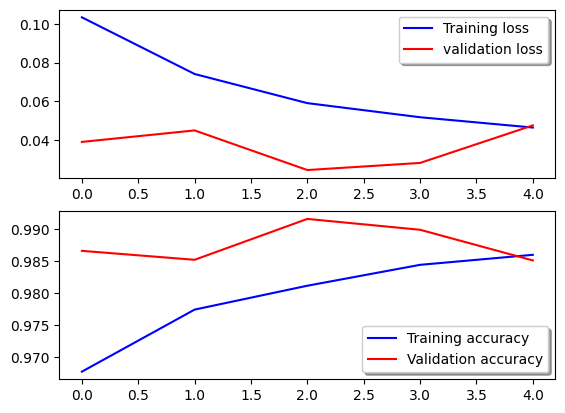

In [49]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#### Confusion matrix

313/313 [==============================] - 2s 6ms/step


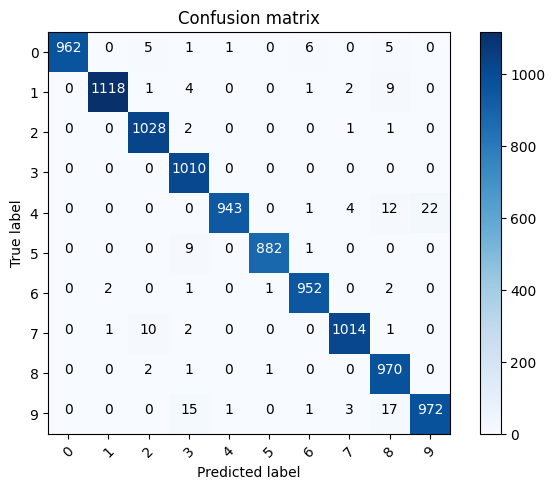

In [60]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In the example, they have used these techniques to evaluate the model:
* Training and validation curves
* Confusion matrix
* Displaying errors 